# Binance HFsigma

## Utilidad de los sigmas de alta frecuencia:
   
* Hedging
* Trading de opciones, basado en screeners
* Arbitrajes de sintéticos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading
import requests
from datetime import datetime

## Consideraciones acerca de Threading

Tiempos de procesamiento de datos

    •	CPU L1 Cache: 0.9 ns
    •	RAM: 51 ns
    •	SSD: 0.08 a 0.15 ms = 80.000 a 150.000 ns 
    •	HDD 7.2k: 4 ms = 4.000.000 ns
    •	Red: 400 ms = 400.000.000 ns

Unidad equivalente 0.9 nanosegunos computacionales = 1 segundo humano

    •	CPU: 1 seg
    •	RAM: 1 minuto
    •	SSD: 1 a 2 dias
    •	HDD: 1mes y medio
    •	Red: 14 años

In [2]:
def historico(symbol, interval='1d', startTime=None, endTime=None, limit=1000):
    
    url = 'https://api.binance.com/api/v3/klines'
    
    params = {'symbol':symbol, 'interval':interval, 
              'startTime':startTime, 'endTime':endTime, 'limit':limit}
        
    r = requests.get(url, params=params)
    js = r.json()
    
    # Armo el dataframe
    cols = ['openTime','Open','High','Low','Close','Volume','cTime',
            'qVolume','trades','takerBase','takerQuote','Ignore']
    
    df = pd.DataFrame(js, columns=cols)
    
    #Convierto los valores strings a numeros
    df = df.apply(pd.to_numeric)
    
    # Le mando indice de timestamp
    df.index = pd.to_datetime(df.openTime, unit='ms')
    
    # Elimino columnas que no quiero
    df =df.drop(['openTime','cTime','takerBase','takerQuote','Ignore'],axis=1)
    
    return df

In [3]:
def historico_bulk(par, inicio, timeframe_minutos=1, n_threads=30):

    ts = int(datetime.timestamp(inicio))*1000
    fechas = []
    while ts < int(datetime.timestamp(datetime.now()))*1000:
        fechas.append((ts, ts+60*1000*1000*timeframe_minutos))
        ts += 60*1000*1000*timeframe_minutos
    
    intervalos = {1:'1m',5:'5m',15:'15m',30:'30m',60:'1h',1440:'1D'}
    interval = intervalos.get(timeframe_minutos)
    subs = np.array_split(fechas, n_threads)
    dfs = []
    def worker(fechas):
        for fecha in fechas:
            try:
                df = historico(par, interval=interval, startTime=fecha[0])
            except:
                time.sleep(0.01)
                df = historico(par, interval=interval, startTime=fecha[0])
            dfs.append(df)
        return df


    threads = []
    for i in range(n_threads):
        t = threading.Thread(target=worker, args=(subs[i],))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    data = pd.concat(dfs).sort_index()
    data.index = pd.to_datetime(data.index)

    data['Cruce_5_20'] = (data.Close.rolling(5).mean() / data.Close.rolling(20).mean() -1)*100
    dif = data['Close'].diff()
    win =  pd.DataFrame(np.where(dif > 0, dif, 0))
    loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
    ema_win = win.ewm(alpha=1/14).mean()
    ema_loss = loss.ewm(alpha=1/14).mean()
    rs = ema_win / ema_loss
    rsi = 100 - (100 / (1+rs))
    rsi.index = data.index
    data['rsi'] = rsi
    return data.dropna()

In [4]:
%%time
inicio = datetime(2017,9,1)
par = 'BTCUSDT'

result = historico_bulk(par, inicio, timeframe_minutos=15)
result

Wall time: 5.29 s


,Open,High,Low,Close,Volume,qVolume,trades,Cruce_5_20,rsi
openTime,,,,,,,,,
2017-09-01 07:45:00,4696.14,4713.00,4692.17,4707.50,12.962762,6.096538e+04,55,0.083195,55.989173
2017-09-01 08:00:00,4715.00,4745.79,4708.09,4708.09,10.954807,5.166458e+04,46,0.271504,56.255703
2017-09-01 08:15:00,4708.09,4762.99,4708.09,4762.99,5.628520,2.665462e+04,64,0.475419,72.776605
2017-09-01 08:30:00,4731.12,4750.00,4731.12,4749.63,4.614370,2.190851e+04,38,0.632340,66.222180
2017-09-01 08:45:00,4750.00,4750.00,4731.00,4749.99,13.831065,6.560014e+04,54,0.823866,66.310228
...,...,...,...,...,...,...,...,...,...
2021-12-19 00:30:00,46662.87,46740.89,46560.38,46611.12,219.083870,1.022080e+07,7875,-0.050800,39.968815
2021-12-19 00:45:00,46607.12,46686.91,46550.00,46664.34,168.617160,7.862080e+06,6539,-0.172383,43.428899
2021-12-19 01:00:00,46664.33,46820.64,46641.46,46787.28,192.283010,8.983154e+06,6359,-0.213132,50.523268


<AxesSubplot:title={'center':'Máxima variación % en velas de 15 minutos, rolling semanal'}, xlabel='openTime'>

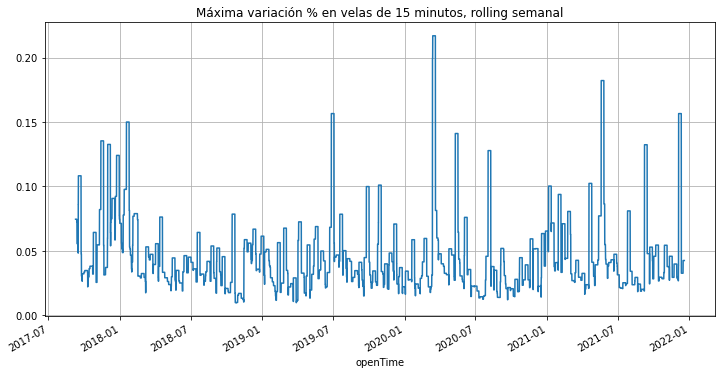

In [5]:
result['amplitud'] = result['High'] - result['Low']
result['px_medio'] = (result['High'] + result['Low'])/2
result['amp_porc'] = result['amplitud'] / result['px_medio']
result['variacion'] = result['Close'].pct_change()
result['sigma_1d'] = result['variacion'].rolling(4*24).std() 
result['spike_sigma'] = result['amp_porc'] / result['sigma_1d']

t = 'Máxima variación % en velas de 15 minutos, rolling semanal'
result.amp_porc.rolling(7*24*4).max().plot(figsize=(12,6), grid=True, title=t)

# Estacionalidad I

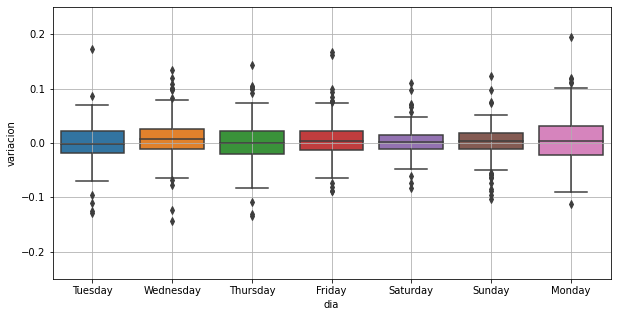

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df = historico('BTCUSDT', interval='1d')
df['dia'] = df.index.day_name()
df['variacion'] = df.Close.pct_change()

plt.figure(figsize=(10,5))
df['dia'] = df.index.day_name()
sns.boxplot(x="dia", y="variacion", data=df)
plt.ylim(-0.25, 0.25)
plt.grid()

(-0.25, 0.25)

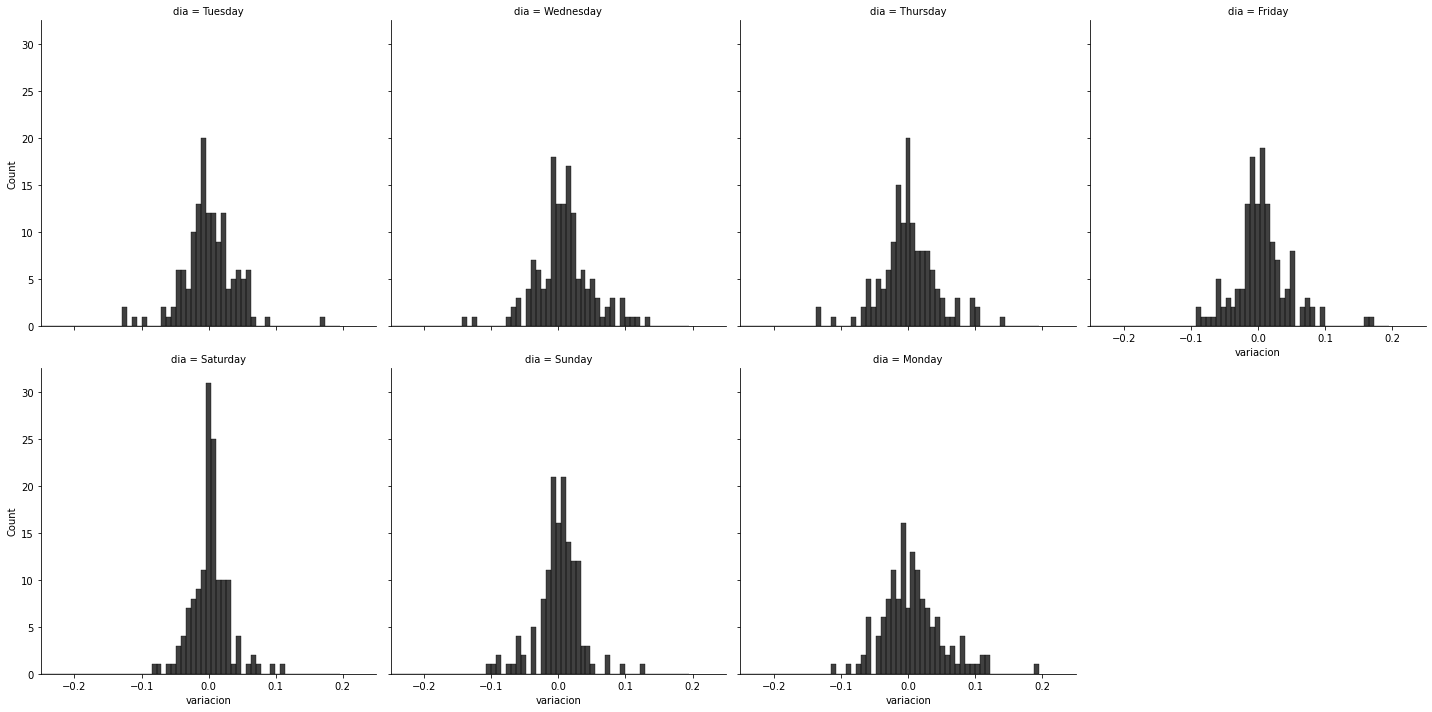

In [7]:
sns.displot(df, x="variacion", col='dia', kind="hist", col_wrap=4, color='k')
plt.xlim(-0.25, 0.25)

# Binance Zscores

## Utilidad de los zscores

* Construcción de osciladores
* Trading de rangos
* Trading de momentum

In [8]:
def paneles():
    url = 'https://api.binance.com/api/v3/ticker/24hr'      
    r = requests.get(url)
    js = r.json()
    df = pd.DataFrame(js)

    todos = df.set_index('symbol').apply(pd.to_numeric)
    usdt_pares = [x for x in list(todos.index) if x[-4:]=='USDT']
    usdt_pares = [x for x in usdt_pares if (x.find('BULL')==-1)&(x.find('BEAR')==-1)]
    usdt_pares = [x for x in usdt_pares if (x.find('DOWN')==-1)&(x.find('UP')==-1)]

    busd_pares = [x for x in list(todos.index) if x[-4:]=='BUSD']
    busd_pares = [x for x in busd_pares if (x.find('BULL')==-1)&(x.find('BEAR')==-1)]
    busd_pares = [x for x in busd_pares if (x.find('DOWN')==-1)&(x.find('UP')==-1)]

    usdt_panel = todos.loc[usdt_pares]
    busd_panel = todos.loc[busd_pares]
    
    paneles = {'USDT':usdt_panel, 'BUSD':busd_panel}
    return paneles

In [9]:
dfs = paneles()
pares = dfs['USDT'].loc[dfs['USDT']['count']>0].index.tolist()

In [10]:
%%time

n_threads = 30
t0, t1 = '2021-09-01', '2021-12-30'


subs = np.array_split(pares, n_threads)
scores = []
def agregador(pares):
    for par in pares:
        try:
            data = historico(par)
        except:
            time.sleep(0.01)
            data = historico(par)

        data = historico(par, interval='1d')
        data['zs_px'] = data.Close.add(-data.Close.mean()).divide(data.Close.std())
        data['zs_vol'] = data.Volume.add(-data.Volume.mean()).divide(data.Volume.std())
        data['zs_comb'] = data['zs_px'] + data['zs_vol']
        data['zs_comb'] = data['zs_comb'] / data['zs_comb'].abs().max()
        r = data.loc[(data.index > t0) & (data.index < t1)].zs_comb.mean()
        scores.append({'par':par,'score':r})

threads = []
for i in range(n_threads):
    t = threading.Thread(target=agregador, args=(subs[i],))
    threads.append(t)
    t.start()

for t in threads:
    t.join()

result = pd.DataFrame(scores).set_index('par')
result.sort_values('score', ascending=False).head(20)

Wall time: 21.4 s


,score
par,
FTMUSDT,0.341971
ATOMUSDT,0.298216
AVAXUSDT,0.289072
JSTUSDT,0.279665
CELRUSDT,0.277443
OMGUSDT,0.273506
TRXUSDT,0.270845
FETUSDT,0.269660
SOLUSDT,0.259992


# Estacionalidad II

## Función Pivot

In [12]:
import yfinance as yf
import seaborn as sns
import numpy as np
import calendar
import matplotlib.pyplot as plt

In [13]:
df = yf.download('^GSPC', auto_adjust=True, progress=False)
df = df.loc[df.index.year > 2010]
df["Year"] = df.index.year
df["Month"] = df.index.month
df = df.resample('M').last()
df['variacion'] = df.Close.pct_change()
tabla = df.pivot_table(index="Year",columns="Month",values="variacion")
tabla

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2011,NaN,0.031957,-0.001047,0.028495,-0.013501,-0.018257,-0.021474,-0.056791,-0.071762,0.107723,-0.005059,0.008533
2012,0.043583,0.040589,0.031332,-0.007497,-0.062651,0.039555,0.012598,0.019763,0.024236,-0.019789,0.002847,0.007068
2013,0.050428,0.011061,0.035988,0.018086,0.020763,-0.014999,0.049462,-0.031298,0.029750,0.044596,0.028049,0.023563
2014,-0.035583,0.043117,0.006932,0.006201,0.021030,0.019058,-0.015080,0.037655,-0.015514,0.023201,0.024534,-0.004189
2015,-0.031041,0.054893,-0.017396,0.008521,0.010491,-0.021012,0.019742,-0.062581,-0.026443,0.082983,0.000505,-0.017530
2016,-0.050735,-0.004128,0.065991,0.002699,0.015325,0.000911,0.035610,-0.001219,-0.001234,-0.019426,0.034175,0.018201
2017,0.017884,0.037198,-0.000389,0.009091,0.011576,0.004814,0.019349,0.000546,0.019303,0.022188,0.028083,0.009832
2018,0.056179,-0.038947,-0.026884,0.002719,0.021608,0.004842,0.036022,0.030263,0.004294,-0.069403,0.017859,-0.091777
2019,0.078684,0.029729,0.017924,0.039313,-0.065778,0.068930,0.013128,-0.018092,0.017181,0.020432,0.034047,0.028590


In [14]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

cmap_jp = LinearSegmentedColormap.from_list('Custom', ('red','black','green'), N=256)

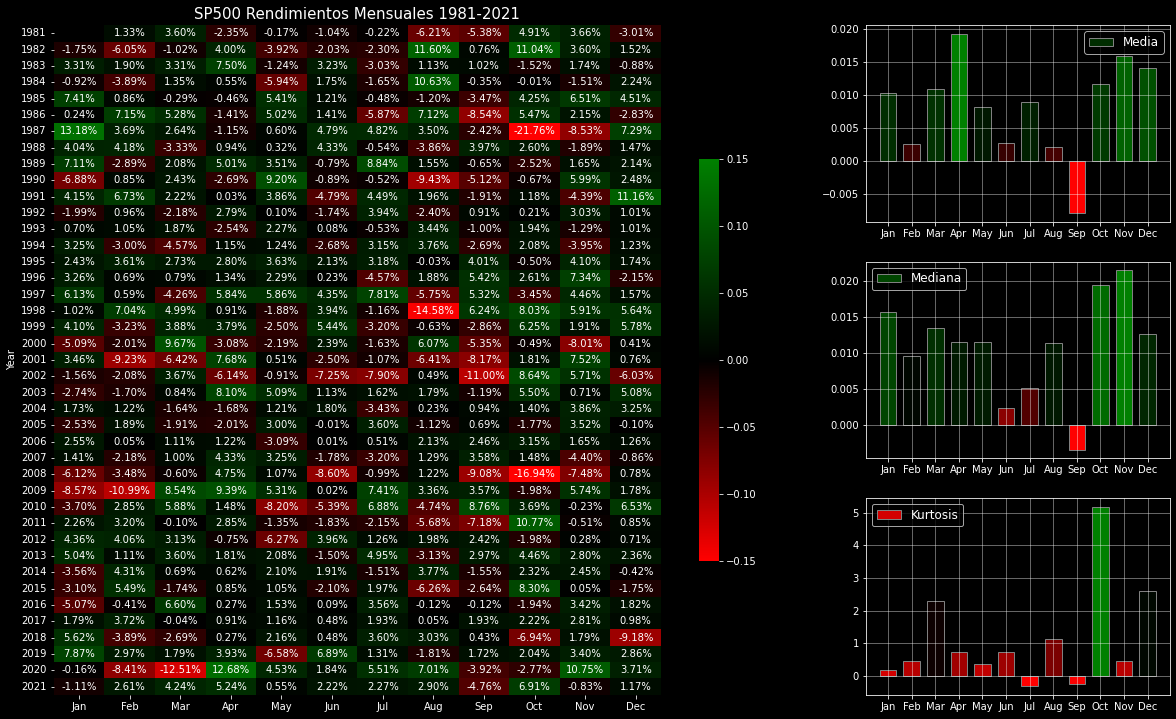

In [15]:
df = yf.download('^GSPC', auto_adjust=True, progress=False)
df = df.loc[df.index.year > 1980].copy()
df["Year"] = df.index.year
df["Month"] = df.index.month
df = df.resample('M').last()
df['variacion'] = df.Close.pct_change()
tabla = df.pivot_table(index="Year",columns="Month",values="variacion")
meses = [x[:3] for x in list(calendar.month_name[1:])]
tabla.columns = meses

plt.style.use('dark_background')
fig = plt.figure(figsize=(20,12))
gs = GridSpec(nrows=3,ncols=2, figure=fig, width_ratios=[2.5,1], hspace=0.2, wspace=0.1, top=.9)
ax_l = fig.add_subplot(gs[:,0])
ax_r = [fig.add_subplot(gs[i,1]) for i in range(3)]

sc = lambda y: (y - y.min()) / (y.max() - y.min())
ax_r[0].bar(meses, tabla.mean(), color=cmap_jp(sc(tabla.mean())), label='Media', width=.7, edgecolor='gray')
ax_r[1].bar(meses, tabla.median(), color=cmap_jp(sc(tabla.median())), label = 'Mediana', width=.7, edgecolor='gray')
ax_r[2].bar(meses, tabla.kurt(), color=cmap_jp(sc(tabla.kurt())), label = 'Kurtosis', width=.7, edgecolor='gray')
[ax_r[i].legend(fontsize=12) for i in range(3)]
[ax_r[i].grid(alpha=.5) for i in range(3)]

sns.heatmap(tabla, annot=True, ax=ax_l, cmap=cmap_jp, fmt='.2%', vmax=0.15, vmin=-0.15, cbar_kws={"shrink": 0.6})
ax_l.set_title('SP500 Rendimientos Mensuales 1981-2021', fontsize=15)
print('\n')
plt.show()
print('\n')

# Pearson corr

$$ \Large \rho_{x,y} = \frac{Cov_{x,y}}{\sigma_x . \sigma_y}  $$

## Utilidad de los indicadores de correlación

* Alpha y Beta de los assets de portafolio, ponderaciones
* Optimización de portafolios (Ej, mínima varianza o cualquier minimización de ratio)
* Feature para trading de ratios

In [16]:
data = historico('BTCUSDT', interval='1d')
data['zs_px'] = (data.Close - data.Close.rolling(30).mean()) / data.Close.rolling(30).std()
data['osc_px'] = (data.Close - data.Close.rolling(30).min()) / (data.Close.rolling(30).max() - data.Close.rolling(30).min())
data['fw'] = data.Close.shift(-30) / data.Close -1 
data

,Open,High,Low,Close,Volume,qVolume,trades,zs_px,osc_px,fw
openTime,,,,,,,,,,
2019-03-26,3935.47,3958.98,3894.00,3948.55,29349.537627,1.153301e+08,192418,NaN,NaN,0.321979
2019-03-27,3948.77,4048.00,3936.15,4038.05,32364.555852,1.296813e+08,224309,NaN,NaN,0.316006
2019-03-28,4039.58,4039.70,4002.00,4027.81,20089.293875,8.082223e+07,157060,NaN,NaN,0.314781
2019-03-29,4028.22,4123.71,4024.03,4103.25,30084.217444,1.225858e+08,203826,NaN,NaN,0.293492
2019-03-30,4104.24,4140.00,4052.00,4106.97,19509.292601,7.985384e+07,162463,NaN,NaN,0.275427
...,...,...,...,...,...,...,...,...,...,...
2021-12-15,48336.95,49500.00,46547.00,48864.98,51629.181000,2.487012e+09,1438176,-1.146458,0.158497,NaN
2021-12-16,48864.98,49436.43,47511.00,47632.38,31949.867390,1.551201e+09,1023983,-1.332038,0.068144,NaN
2021-12-17,47632.38,47995.96,45456.00,46131.20,43104.488700,2.015966e+09,1261780,-1.559264,0.000000,NaN


<AxesSubplot:xlabel='openTime'>

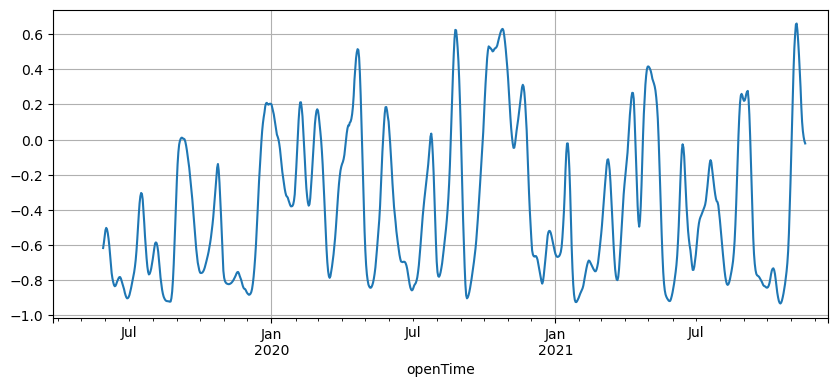

In [24]:
plt.style.use('default')
data.zs_px.rolling(30).corr(data.fw).rolling(7).mean().plot(figsize=(10,4), grid=True)

<AxesSubplot:>

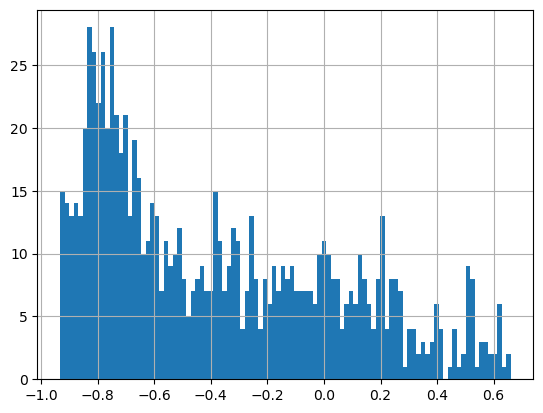

In [25]:
data.zs_px.rolling(30).corr(data.fw).rolling(7).mean().hist(bins=100)

<AxesSubplot:xlabel='openTime'>

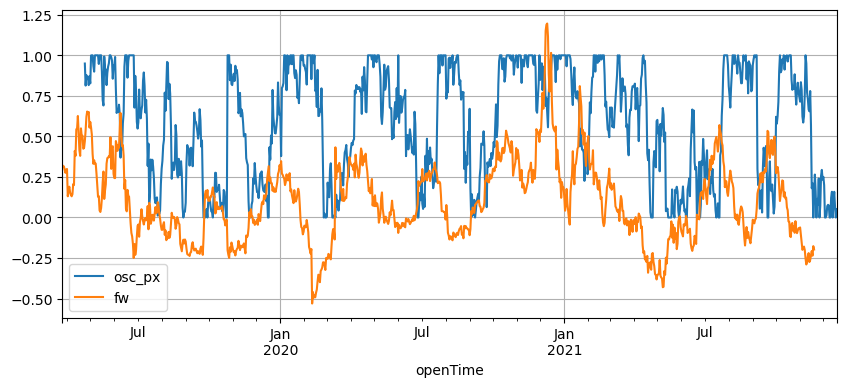

In [27]:
data.iloc[:,-2:].plot(figsize=(10,4), grid=True)

# Estadísticos

## Utilidad de los estadísticos

* Indicadores Referenciales
* Son descriptivos
* Tests de hipótesis y contrastes en estadistica inferencial

$$ {\displaystyle \sigma _{n}^{2}={\frac {1}{n}}\sum _{i=1}^{n}\left(X_{i}-{\overline {X}}\right)^{2}} $$

$$ {\displaystyle skew =\sum _{i=1}^{n} \frac{\left(X_{i}-{\overline {X}}\right)^{3}}{\sigma^3}} $$

$$ {\displaystyle kurtosis =\sum _{i=1}^{n} \frac{\left(X_{i}-{\overline {X}}\right)^{4}}{\sigma^4}} $$

[*********************100%***********************]  1 of 1 completed


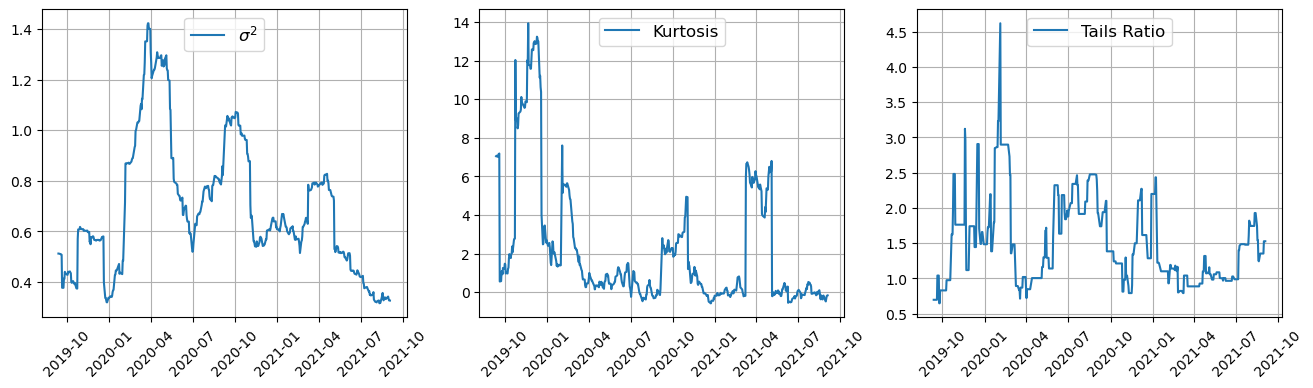

In [28]:
import yfinance as yf
import pandas as pd

data = yf.download('TSLA', auto_adjust=True, end='2021-09-04')
data['retornos'] = data['Close']/data['Close'].shift() -1

roll = data.retornos.rolling(40)
data['sigma_40'] = roll.std() * 250**0.5
data['kurtosis'] = roll.apply(pd.DataFrame.kurtosis)
data['tails_ratio'] = roll.quantile(.95) / roll.quantile(.05).abs()


fig, ax = plt.subplots(figsize=(16,4), ncols=3)
df = data.iloc[-500:]

ax[0].plot(df['sigma_40'], label= r'$\sigma^2$')
ax[1].plot(df['kurtosis'], label='Kurtosis')
ax[2].plot(df['tails_ratio'], label='Tails Ratio')

for i in range(3):
    ax[i].grid()
    ax[i].legend(loc='upper center', fontsize=12)
    ax[i].tick_params(axis='x', rotation=45)


# Ratios Referenciales

## Alpha

$$ \Large \alpha = R - R_b $$

$$ \Large \overline{\alpha_w} =  \sum_{i=1}^w \frac{R_i-R_{b_i}}{w} $$

## Beta

$$ \Large \beta = \frac{Cov{(R - R_b)}}{\sigma^2_{R_b}} $$

$$ \Large \overline{\beta_w} =  \frac{\sum_{j=1}^w(R_j-\overline{R})(R_{b_j}-\overline{R_b})}{ \sum_{j=1}^w (R_{b_j} - \overline{R})^2} $$

## Sharpe

$$ \Large sharpe =  \frac{R - F_{_{RISK}}}{\sigma_R} $$

$$ \Large \overline{sharpe}_w  =  \frac{ \sum_{i=1}^w R_i - F_{_{risk}}}{\frac{1}{w} \sum_{i=1}^w\sum_{i=1}^n \frac{ (R_{i} - \overline{R})^2}{n}} $$

## Information Ratio

$$ \Large  IR = \frac{R - R_b}{\sigma_{(R-R_b)}} = \frac{\alpha}{\sigma_{\alpha}}  $$

$$  \Large \overline{IR}_w = \frac{\sum_{i=1}^w \frac{R_i-R_{b_i}}{w}}{\sum_{i=1}^w \frac{ (R_{i}-R_{b_i} - \overline{R-R_b} )^2}{w}} $$

In [29]:
import yfinance as yf
import numpy as np

data = yf.download(['TSLA','SPY'], auto_adjust=True, end='2021-09-04')['Close']
data['R'] = data['TSLA']/data['TSLA'].shift() -1
data['Rb'] = data['SPY']/data['SPY'].shift() -1
data['alpha'] = data.R - data.Rb
data['sigma_40'] = data.R.rolling(40).std() 

rf = 0
w = 100
roll = data.rolling(w)
data['rolling_alfa'] = roll.alpha.mean()
data['rolling_beta'] = roll.R.cov(data.Rb) / roll.Rb.var()

data['rolling_sharpe'] = roll.R.mean() / roll.sigma_40.mean()
data['rolling_IR'] = roll.alpha.mean() / roll.alpha.std()
data.dropna()

[*********************100%***********************]  2 of 2 completed


,SPY,TSLA,R,Rb,alpha,sigma_40,rolling_alfa,rolling_beta,rolling_sharpe,rolling_IR
Date,,,,,,,,,,
2011-01-14,104.568657,5.150000,-0.017925,0.007245,-0.025170,0.042133,0.001593,0.975467,0.095350,0.039457
2011-01-18,104.746544,5.128000,-0.004272,0.001701,-0.005973,0.042053,0.001208,0.967230,0.085266,0.029997
2011-01-19,103.719452,4.806000,-0.062792,-0.009805,-0.052987,0.042585,0.000686,1.068931,0.071416,0.016893
2011-01-20,103.581963,4.524000,-0.058677,-0.001326,-0.057351,0.041192,0.000293,1.144435,0.057264,0.007148
2011-01-21,103.816521,4.608000,0.018568,0.002264,0.016303,0.040823,0.000225,1.217694,0.059904,0.005486
...,...,...,...,...,...,...,...,...,...,...
2021-08-30,449.204773,730.909973,0.026674,0.004398,0.022277,0.021652,-0.000072,1.239503,0.032777,-0.002906
2021-08-31,448.539246,735.719971,0.006581,-0.001482,0.008062,0.021087,0.000181,1.261686,0.038547,0.007321
2021-09-01,448.777649,734.090027,-0.002215,0.000532,-0.002747,0.020695,-0.000212,1.267253,0.025860,-0.008683


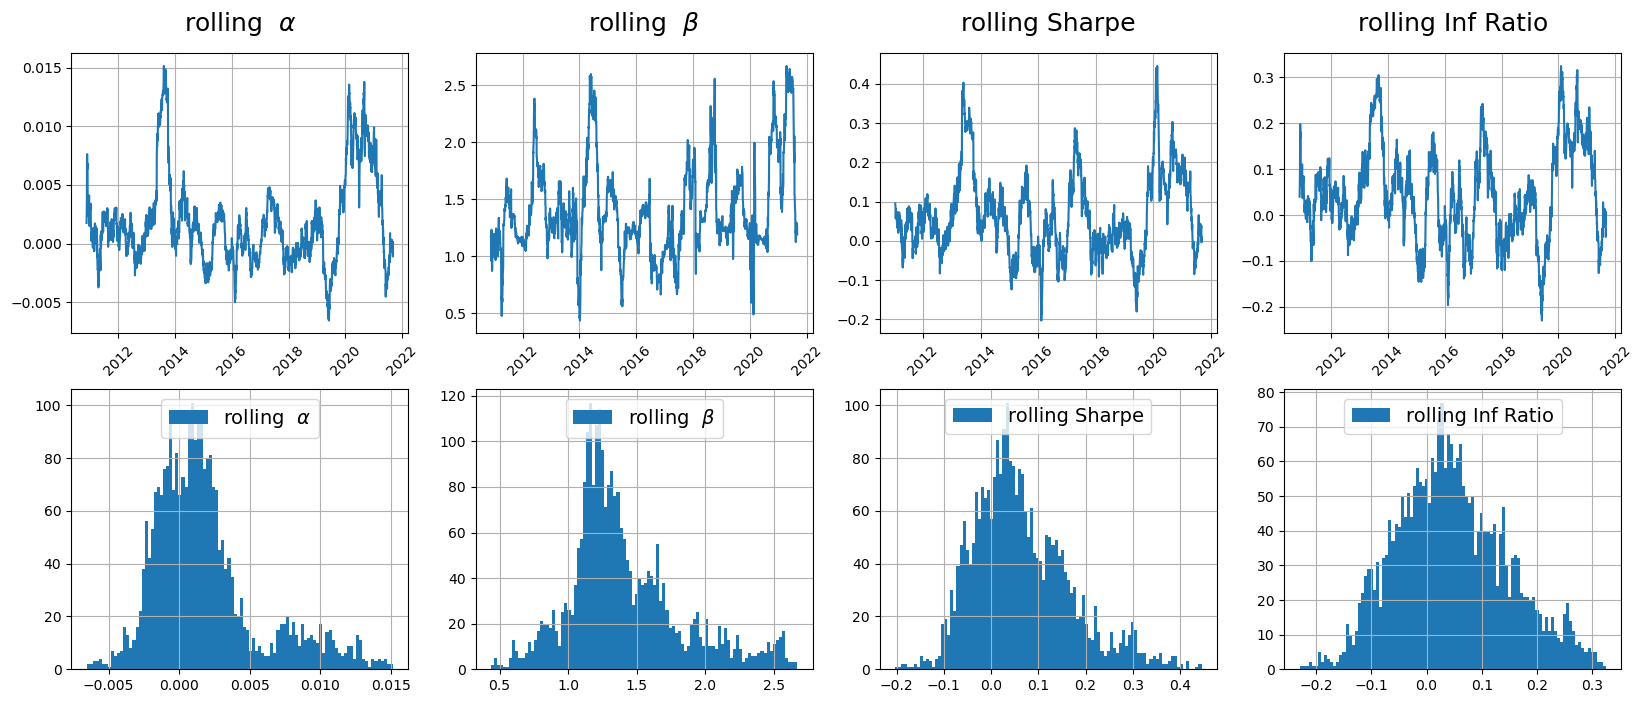

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8), ncols=4, nrows=2)
series = {'rolling_alfa':  r'rolling  $\alpha$',
          'rolling_beta' : r'rolling  $\beta$',
          'rolling_sharpe': 'rolling Sharpe',
          'rolling_IR': 'rolling Inf Ratio' }

for i, item in enumerate(series.items()):
    ax[0][i].set_title(item[1], fontsize=18, y=1.05)
    ax[0][i].plot(data[item[0]])
    ax[0][i].grid()
    ax[0][i].tick_params(axis='x', rotation=45)

    ax[1][i].hist(data[item[0]].dropna(), label=item[1], bins=100)
    ax[1][i].legend(loc='upper center', fontsize=14)
    ax[1][i].grid()